In [1]:
import numpy as np
import zipfile
import random
from scipy.misc import imread
import tensorflow as tf

from matplotlib import gridspec 
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
zip_ref = zipfile.ZipFile('galaxy_zoo_icp_sample.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [3]:
types = ['cigar_shaped','comp_round']#,'mid_round','no_bar_arm','no_bar_no_arm']
n_types = len(types)

def data_provider(n,n_train = 900,n_data=1000,data_set='train',crop=0):
    
    images = np.zeros((n_types*n,424-crop,424-crop,3))
    labels = np.zeros((n_types*n,n_types))
    
    k = 0
    for i,typ in enumerate(types):
        
        if data_set=='train':
            lst = np.arange(n_train)
        else:
            lst = np.arange(n_train,n_data)
        random.shuffle(lst)
        for j in lst[:n]:
            images[k,:,:,:] = imread('./galaxy_zoo_icp/'+typ+'_'+str(j))[crop//2:424-crop//2,crop//2:424-crop//2,:]
            labels[k,i] =1 
            k += 1
        
    return images,labels

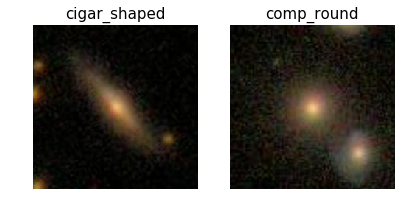

In [9]:
crop = 200
images,labels = data_provider(1,crop=crop)

fig = plt.figure()
fig.set_size_inches(10, 7)
gs = gridspec.GridSpec(2, 3)

for i in range(n_types):
    ax = fig.add_subplot(gs[i//3,i%3])
    ax.imshow(images[i].astype(np.uint8))
    ax.axis('off')
    ax.set_title(types[i],fontsize=15)

In [9]:
x_in = tf.placeholder(tf.float32, shape=[None,424-crop,424-crop,3])

y_ = tf.placeholder(tf.float32, shape=[None,n_types])
keep_prob = tf.placeholder(tf.float32)

x = tf.layers.conv2d(x_in,filters=5,kernel_size=(7,7),strides=(2, 2),activation=tf.nn.relu)
x = tf.layers.max_pooling2d(x,pool_size=2,strides=2)
x = tf.layers.conv2d(x,filters=3,kernel_size=(5,5),strides=(2, 2),activation=tf.nn.relu)
x = tf.layers.conv2d(x,filters=2,kernel_size=(3,3),strides=(2, 2),activation=tf.nn.relu)
x = tf.layers.max_pooling2d(x,pool_size=2,strides=2)
x = tf.contrib.layers.flatten(x)
x = tf.layers.dense(x, 200, activation=tf.nn.relu)
x = tf.layers.dropout(x, keep_prob)
Ylogits = tf.layers.dense(x,n_types)
predict = tf.nn.softmax(Ylogits)
classes = tf.argmax(predict, 1)

cross_entropy = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=y_, logits=Ylogits))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(classes, tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)  

In [10]:
def train(n_epoch,crop=0):
    accu = np.zeros(n_epoch)
    for i in range(n_epoch):
        xp,yp = data_provider(100,crop=crop)
        accu[i] = accuracy.eval(feed_dict={x_in: xp, y_: yp, keep_prob: 1.0})
        if i % 10 == 0:
            print('Epoch: {:d}, accuracy: {:2.2f}'.format(i, accu[i]))
        train_step.run(feed_dict={x_in: xp, y_: yp, keep_prob: 0.8})
        
    return accu

accu = train(100,crop=crop)

Epoch: 0, accuracy: 0.57
Epoch: 10, accuracy: 0.50
Epoch: 20, accuracy: 0.69
Epoch: 30, accuracy: 0.67
Epoch: 40, accuracy: 0.62
Epoch: 50, accuracy: 0.75
Epoch: 60, accuracy: 0.71
Epoch: 70, accuracy: 0.74
Epoch: 80, accuracy: 0.77
Epoch: 90, accuracy: 0.76


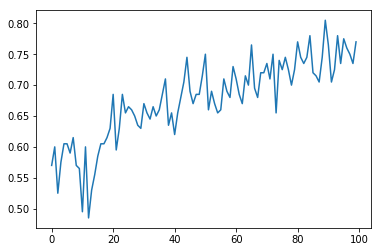

In [11]:
plt.plot(accu)

In [14]:
xp,yp = data_provider(100,data_set='test',crop=crop)
train_accuracy = accuracy.eval(feed_dict={x_in: xp, y_: yp, keep_prob: 1.0})
print('Test set accuracy is {:2.2f}.'.format(train_accuracy))

Test set accuracy is 0.79
